Este notebook é um tutorial de fine-tunning para comparação de fewshot com sentence-transformer e do GPT3/3.5 e zero-shot ChatGPT.

https://github.com/thacio/Few-Shot-Editais-TI

# Inicialização das variáveis

In [ ]:
inserir_beginoftext_token = False
MAX_TOKEN_GENERATION_LENGTH=10

output_dir="/content/fine-tuned-model"

transformer_model_name='tgsc/ult5-pt-small'; model_type='encoder-decoder';
dropout_rate=0.0;

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import multiprocessing

num_proc = multiprocessing.cpu_count()
print('cpu_count:',num_proc)

Tue May  9 13:12:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install datasets
!pip install transformers accelerate
!pip install sentencepiece
!pip install evaluate
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Carrega o tokenizer

In [ ]:
import transformers as transformers
from transformers import AutoTokenizer, AutoConfig

tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)

# Carrega o modelo

In [ ]:
import transformers
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM
import torch

model = AutoModelForSeq2SeqLM.from_pretrained(transformer_model_name,dropout_rate=dropout_rate)   

model.max_length=MAX_TOKEN_GENERATION_LENGTH

# context_length é o tamanho máximo do modelo
try:
    context_length=model.config.n_positions
except:
    context_length=model.config.max_position_embeddings

print(model.config)
model_size = sum(t.numel() for t in model.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

T5Config {
  "_name_or_path": "tgsc/ult5-pt-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "bos_token_id": 50257,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "silu",
  "dropout_rate": 0.0,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-silu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 1024,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50361
}

Model size: 82.4M parameters


# Preparação do dataset

Para que os resultados sejam reproduzíveis, os parâmetos de geração do dataset não devem ser alterados (*test_size* para a geração dos datasets do few shot e validação, assim como os *seeds* para obter as amostras.

Os valores foram escolhidos de forma a restar 50 exemplos de cada classe no dataset de treino.


## Download e split no dataset

In [ ]:
!wget https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx

--2023-05-09 13:46:48--  https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx [following]
--2023-05-09 13:46:48--  https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702524 (686K) [application/octet-stream]
Saving to: ‘editais_TI.xlsx.5’

editais_TI.xlsx.5   100%[===================>] 686.06K  --.-KB/s    in 0.02s   

2023-05-09 13:46:49 (36.3 MB/s) - ‘editais_TI.xlsx.5’ saved [702524/702524]



Carrega o dataset e elimina as linhas duplicadas

In [ ]:
import pandas
import numpy

df = pandas.read_excel('editais_TI.xlsx')
df['CLASSE_TI'] = df['CLASSE_TI'].replace({0: 'Outras compras', 1: 'Tecnologia da Informação'})
df['DES_OBJETO'] = df['DES_OBJETO'].str.replace('Objeto: Pregão Eletrônico - ', '').str.strip()
df = df[~df['DES_OBJETO'].duplicated()] # Remove colunas com objeto duplicado

df.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,0,153038,12019,O objeto da presente licitação é de empresa pa...,Outras compras
1,1,153054,122019,Registro de Preços para futuras aquisições de ...,Outras compras
2,2,153054,152019,Registro de preços para futuras aquisições de ...,Outras compras
3,3,153054,192019,Contratação de empresa para prestação de servi...,Outras compras
4,4,153054,332019,Registro de preço para futuras aquisições de Ó...,Outras compras


Cria o split temporário de validação e de treino. Ele será alterado mais a frente

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
df_train, df_validation = train_test_split(df, test_size=0.9408,random_state=43)

df_validation.loc[df_validation['CLASSE_TI'] == 1]
len(df_validation.loc[df_validation['CLASSE_TI'] == 1])/len(df_validation)

df_train.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
4721,4721,240104,172018,"Aquisição de Licenças de uso de Softwares, gar...",Tecnologia da Informação
3488,3488,160036,112018,Registro de preços para atender as necessidade...,Outras compras
2233,2233,153163,3522018,Registro de Preços para a eventual aquisição d...,Outras compras
5163,5163,253002,182018,Contratação de empresa especializada no fornec...,Tecnologia da Informação
863,863,120195,1652018,Contratação de serviços continuados de limpeza...,Outras compras


## Equilibra as classes no set da instrução e move o restante para a validação

*Este código está sendo executado aqui para fins de reprodução dos datasets*

Como estamos trabalhando com few-shot, todos os excessos de classe do dataset de treinamento (que será transformado em few-shot) será transferido para o dataset de validação, de forma a equilibrar as classes.

In [ ]:
import pandas as pd
import numpy as np

# Count the number of 0s and 1s in the 'CLASSE_TI' column of the 'df_train' dataframe
num_0 = df_train['CLASSE_TI'].value_counts()[0]
num_1 = df_train['CLASSE_TI'].value_counts()[1]

# Calculate the difference between the number of 0s and 1s
diff = num_0 - num_1

# If the difference is greater than 0, randomly select that many rows from 'df_train' with label 0 and append them to 'df_validation'
if diff > 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Outras compras'].sample(n=diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is less than 0, randomly select that many rows from 'df_train' with label 1 and append them to 'df_validation'
elif diff < 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Tecnologia da Informação'].sample(n=-diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is already 0, do nothing
else:
    pass

## Estatística do datset

In [ ]:
# Get the number of examples in each dataframe
num_train_examples = len(df_train)
num_validation_examples = len(df_validation)

# Get the number of examples in each class for each dataframe
train_class_counts = df_train['CLASSE_TI'].value_counts()
validation_class_counts = df_validation['CLASSE_TI'].value_counts()

# Calculate the percentage of each class for each dataframe
train_class_percents = train_class_counts / num_train_examples * 100
validation_class_percents = validation_class_counts / num_validation_examples * 100

# Calculate the percentage of the validation set compared to the total
validation_percent_total = num_validation_examples / (num_train_examples + num_validation_examples) * 100

# Calculate the ratio of the number of examples in each class between the validation and training sets
class_ratio_0 = validation_class_counts[0] / (train_class_counts[0]+validation_class_counts[0]) * 100
class_ratio_1 = validation_class_counts[1] / (train_class_counts[1]+validation_class_counts[1]) * 100

# Print out the results
print("Training Data Stats:")
print(f"Total examples: {num_train_examples}")
print(f"Class 0 count: {train_class_counts[0]}, Class 0 percent: {train_class_percents[0]:.2f}%")
print(f"Class 1 count: {train_class_counts[1]}, Class 1 percent: {train_class_percents[1]:.2f}%")
print()

print("Validation Data Stats:")
print(f"Total examples: {num_validation_examples}")
print(f"Class 0 count: {validation_class_counts[0]}, Class 0 percent: {validation_class_percents[0]:.2f}%")
print(f"Class 1 count: {validation_class_counts[1]}, Class 1 percent: {validation_class_percents[1]:.2f}%")
print()
print(f"Percentage of validation set compared to total: {validation_percent_total:.2f}%")
print(f"Class 0 ratio (val/total): {class_ratio_0:.2f}%")
print(f"Class 1 ratio (val/total): {class_ratio_1:.2f}%")

Training Data Stats:
Total examples: 100
Class 0 count: 50, Class 0 percent: 50.00%
Class 1 count: 50, Class 1 percent: 50.00%

Validation Data Stats:
Total examples: 6545
Class 0 count: 5629, Class 0 percent: 86.00%
Class 1 count: 916, Class 1 percent: 14.00%

Percentage of validation set compared to total: 98.50%
Class 0 ratio (val/total): 99.12%
Class 1 ratio (val/total): 94.82%


Utilizaremos a biblioteca datasets do huggingface para reprodução do mesmo dataset e comparação com few-shot do SetFit e GPT3 e zero-shot do ChatGPT

In [ ]:
import datasets
from datasets import load_dataset

ds_train = datasets.Dataset.from_pandas(df_train)
ds_validation = datasets.Dataset.from_pandas(df_validation)

dataset = datasets.DatasetDict({
    'train' : ds_train,
    'validation' : ds_validation
    })

In [ ]:
from datasets import Dataset

# Adaptação de função do setfit para tirar amostras iguais das classes do dataframe
def sample_dataset(dataset: Dataset, label_column: str = "label", num_samples: int = 12, seed: int = 42) -> Dataset:
    """Samples a Dataset to create an equal number of samples per class (when possible)."""
    df = dataset.to_pandas()
    df = df.groupby(label_column)

    # sample num_samples, or at least as much as possible
    df = df.apply(lambda x: x.sample(min(num_samples, len(x)),random_state=seed))
    df = df.reset_index(drop=True)

    all_samples = Dataset.from_pandas(df)
    return all_samples

## Cria o dataset de few-shot

Selecionamos 6 exemplos de cada classe para o few-shot.

Para a validação, selecionaremos 50 exemplos de cada classe, para um total de 100.

In [ ]:
few_shot_dataset = sample_dataset(dataset["train"], label_column="CLASSE_TI", num_samples=6,seed=42)
few_shot_dataset = few_shot_dataset.shuffle(seed=42)
eval_dataset = sample_dataset(dataset["validation"], label_column="CLASSE_TI", num_samples=50,seed=42)
eval_dataset = eval_dataset.shuffle(seed=42)

In [ ]:
few_shot_dataset_df = few_shot_dataset.to_pandas()
few_shot_dataset_df.to_excel('few_shot_prompt.xlsx', index=False)
print('Dataset do prompt de few-shot')
few_shot_dataset_df

Dataset do prompt de few-shot


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,__index_level_0__
0,66,20001,42018,Prestação de serviços de operação e suporte da...,Outras compras,66
1,181,201014,52019,"Aquisição de uma Solução de Gestão Jurídica, c...",Tecnologia da Informação,181
2,4466,200109,82018,Registro de preços para eventual aquisição de ...,Tecnologia da Informação,4466
3,1122,130011,82018,Contratação de serviços continuados de analise...,Tecnologia da Informação,1122
4,5619,323031,342018,Contratação de serviços continuados de apoio t...,Tecnologia da Informação,5619
5,4624,200233,82018,Registro de Preço para aquisição de ESPARGIDOR...,Outras compras,4624
6,3431,160106,572018,Registro de preço para possível aquisição de i...,Outras compras,3431
7,5217,254445,3722018,"Registro de Preços, pelo prazo de até 12 meses...",Outras compras,5217
8,3751,160166,202018,"Contratação de serviços de coleta, transporte,...",Outras compras,3751
9,4992,238014,5982018,Solução comunicação privada e corporativa com ...,Tecnologia da Informação,4992


In [ ]:
print('Dataset de validação')
df_eval = eval_dataset.to_pandas()
df_eval

Dataset de validação


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras
...,...,...,...,...,...
95,5179,254420,702018,Aquisição de Cluster Upgrade - Servidor HPE Pr...,Tecnologia da Informação
96,4454,200036,52018,Contratação de empresa especializada para a pr...,Outras compras
97,4751,200100,822018,Registro de Preços para renovação de subscriçã...,Tecnologia da Informação
98,389,50001,1612018,Aquisição de monitores de vídeo.,Tecnologia da Informação


## Ajuste - aumento da classe de treino

Como estamos em fine-tunning, precisamos de muitos dados. Todos os exemplos que não estão no dataset de validação com 100 exemplos farão parte do dataset de treino

In [ ]:
df_train_finetune = df[~df['DES_OBJETO'].isin(df_eval['DES_OBJETO'])]
print('tamanho do dataset original deduplicado',len(df))
print('tamanho do dataset de treino',len(df_train_finetune))
print('tamanho do dataset de validação',len(df_eval))

tamanho do dataset original deduplicado 6645
tamanho do dataset de treino 6545
tamanho do dataset de validação 100


Vamos apenas conferir se nenhum exemplo do dataset de validação está no dataset de treino

In [ ]:
train_objetos = df_train_finetune['DES_OBJETO']
duplicado = False
for idx, row in df_eval.iterrows():
    if row['DES_OBJETO'] in train_objetos:
        duplicado = True

if duplicado==False:
    print('Tudo ok, sem duplicações')
else:
    print('exemplos de validação no dataset de treino')

Tudo ok, sem duplicações


## Carrega o dataset na biblioteca datasets do huggingface

https://huggingface.co/docs/datasets/loading

In [ ]:
import datasets
from datasets import load_dataset

ds_train = datasets.Dataset.from_pandas(df_train_finetune)
ds_validation = datasets.Dataset.from_pandas(df_eval)

ds = datasets.DatasetDict({
    'train' : ds_train,
    'validation' : ds_validation
    })

ds

# define a função de map para ser aplicada ao dataset
def mrpc_map_enc_dec_function(examples):
    new_examples = { 'text':[], 'labels':[]}
   
    first_key=list(examples.keys())[0]
    for i in range(0,len(examples[first_key])):
        input=f'{examples["DES_OBJETO"][i]}'
        label=f'{examples["CLASSE_TI"][i]}'

        label += tokenizer.eos_token


        new_examples['text'].append(input)
        new_examples['labels'].append(label)

    return new_examples

# aplica a função
ds_processado = datasets.DatasetDict({'train' : None,'validation' : None})

for key in ds_processado.keys():
  ds_processado[key] = ds[key].map(
        mrpc_map_enc_dec_function,
        batched=True,
        batch_size=1_000,
        remove_columns=ds[key].column_names,
        num_proc=2
    )    
print(ds_processado)
print(ds_processado['train'][0])

Map (num_proc=2):   0%|          | 0/6545 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6545
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 100
    })
})
{'text': 'O objeto da presente licitação é de empresa para realização de serviços técnicos especializados na área de tecnologia da informação, contemplando a implantação e execução continuada das atividades de Gerenciamento e Operação da Central de Serviços de TIC de 1º, 2º e 3º níveis, para atender às necessidades da Universidade Federal da Bahia, em seus diversos órgãos e unidades situados nas cidades de Salvador, Vitória da Conquista, Oliveira dos Campinhos (Santo Amaro) e Camaçari, conforme condições, quantidades e exigências estabelecidas neste Edital e seus anexos.', 'labels': 'Outras compras<|endoftext|>'}


## Tokeniza o dataset

In [ ]:
is_validation_ds = False
def tokenize_dataset(examples):

    examples['input_ids']=tokenizer(examples['text'],
                      return_attention_mask=False,
                      truncation=True,
                      max_length=context_length,
                      )['input_ids']

    examples['labels']=tokenizer(examples['labels'],
                      return_attention_mask=False,
                      truncation=True,
                      max_length=context_length,
                      )['input_ids']

    # Insere o eos_token_id caso não tenha sido inserido anteriormente
    for i, label in enumerate(examples['labels']):
        try:
            if label[len(label)-1]!=tokenizer.eos_token_id:
                examples['labels'][i] += [tokenizer.eos_token_id]            
        except:
            # Caso por erro do dataset não haja label
            examples['labels'][i] = [tokenizer.eos_token_id]            
            pass
        # Nos decoders Nos datasets de validação, precisamos inseri
        if model_type=='decoder' and is_validation_ds:
            examples['labels'][i] = [500_000] + label

    return examples

ds_tokenizado = datasets.DatasetDict({'train':None, 'validation': None})

ds_tokenizado['train'] = ds_processado['train'].map(
    tokenize_dataset,
    batched=True,
    batch_size=1_000,
    num_proc=2,
    remove_columns=['text']
)

is_validation_ds = True
ds_tokenizado['validation'] = ds_processado['validation'].map(
    tokenize_dataset,
    batched=True,
    batch_size=1_000,
    num_proc=2,
    remove_columns=['text']
)
is_validation_ds = False

print(ds_tokenizado)
print(ds_tokenizado['train'][0])

Map (num_proc=2):   0%|          | 0/6545 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 6545
    })
    validation: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 100
    })
})
{'labels': [9482, 23382, 1], 'input_ids': [48, 5674, 305, 2965, 33652, 376, 260, 2099, 360, 6862, 260, 3416, 11548, 20799, 363, 1083, 260, 5365, 305, 5468, 13, 27536, 9557, 262, 12950, 259, 7444, 41679, 517, 3555, 260, 49736, 259, 10643, 305, 3781, 260, 14664, 260, 349, 4921, 260, 308, 939, 13, 327, 939, 259, 530, 939, 6244, 13, 360, 12677, 1317, 10813, 305, 1291, 2646, 305, 4070, 13, 302, 774, 2896, 8427, 259, 4464, 25855, 699, 2985, 260, 4979, 13, 4569, 305, 26023, 13, 4604, 428, 3902, 2430, 324, 17769, 17639, 10, 259, 17026, 285, 1549, 13, 6187, 4078, 13, 13829, 259, 21352, 18954, 4238, 1361, 954, 259, 774, 9129, 263, 15]}


## Cria a métrica de validação do dataset

### Métrica de avaliação do dataset

In [ ]:
import evaluate
from evaluate import load

def metric_fn(predictions,labels):
    result = {}

    exact_match_metric = load("exact_match")
    res = exact_match_metric.compute(predictions=predictions,references=labels)
    result.update({'eval_accuracy': res['exact_match']})

    for i in range(0,len(predictions)):
        if predictions[i]=='Tecnologia da Informação':
            predictions[i]=1
        elif predictions[i]=='Outras compras':
            predictions[i]=0
        if labels[i]=='Tecnologia da Informação':
            labels[i]=1
        elif labels[i]=='Outras compras':
            labels[i]=0
            

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'recall_TI': res['recall']})

    precision_metric = evaluate.load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'precision_TI': res['precision']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'recall_outros': res['recall']})

    precision_metric = evaluate.load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'precision_outros': res['precision']})

    return result

### Função de computo da métrica com geração de texto

No caso de decoders, a função da métrica de avaliação recebe o texto inteiro 'input + labels', então precisamos processar a string recebida pela função para separar o input do label para, em seguida, calcular a métrica

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    result = {}    

    predictions=list(predictions)
    labels=list(labels)
    
    for i in range(0,len(labels)):
        # remove  os ids que não podem ser decodificados
        labels[i] = list(filter(lambda x: x!= -100, labels[i]))
        predictions[i] = list(filter(lambda x: x!= -100, predictions[i]))

        # remove os pad_tokens
        labels[i] = list(filter(lambda x: x!= tokenizer.pad_token_id, labels[i]))
        predictions[i] = list(filter(lambda x: x!= tokenizer.pad_token_id, predictions[i]))

        # remove os eos_tokens
        labels[i] = list(filter(lambda x: x!= tokenizer.eos_token_id, labels[i]))
        predictions[i] = list(filter(lambda x: x!= tokenizer.eos_token_id, predictions[i]))

    
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # print('Decoded labels')
    # print(decoded_labels)
    # print('Decoded predictions')
    # print(decoded_preds)
    
    result = metric_fn(decoded_preds,decoded_labels)

    return result

# DataCollator para Encoder-Decoder (Causal Language Modeling)

A única modificação feita do código original é silenciar o tokenizador durante o pad
https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/data/data_collator.py

In [ ]:
import random
import warnings
from collections.abc import Mapping
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union

from transformers.models.bert import BertTokenizer, BertTokenizerFast
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy

@dataclass
class DataCollatorForSeq2SeqModified:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        model ([`PreTrainedModel`]):
            The model that is being trained. If set and has the *prepare_decoder_input_ids_from_labels*, use it to
            prepare the *decoder_input_ids*
            This is useful when using *label_smoothing* to avoid calculating loss twice.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignored by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: PreTrainedTokenizerBase
    model: Optional[Any] = None
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def __call__(self, features, return_tensors=None):
        if return_tensors is None:
            return_tensors = self.return_tensors
        labels = [feature["labels"] for feature in features] if "labels" in features[0].keys() else None

        previous_level = transformers.logging.get_verbosity()
        transformers.logging.set_verbosity_error()     

        # We have to pad the labels before calling `tokenizer.pad` as this method won't pad them and needs them of the
        # same length to return tensors.
        if labels is not None:
            max_label_length = max(len(l) for l in labels)
            if self.pad_to_multiple_of is not None:
                max_label_length = (
                    (max_label_length + self.pad_to_multiple_of - 1)
                    // self.pad_to_multiple_of
                    * self.pad_to_multiple_of
                )

            padding_side = self.tokenizer.padding_side
            for feature in features:
                remainder = [self.label_pad_token_id] * (max_label_length - len(feature["labels"]))
                if isinstance(feature["labels"], list):
                    feature["labels"] = (
                        feature["labels"] + remainder if padding_side == "right" else remainder + feature["labels"]
                    )
                elif padding_side == "right":
                    feature["labels"] = np.concatenate([feature["labels"], remainder]).astype(np.int64)
                else:
                    feature["labels"] = np.concatenate([remainder, feature["labels"]]).astype(np.int64)

        features = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=return_tensors,
        )
        

        # prepare decoder_input_ids
        if (
            labels is not None
            and self.model is not None
            and hasattr(self.model, "prepare_decoder_input_ids_from_labels")
        ):
            decoder_input_ids = self.model.prepare_decoder_input_ids_from_labels(labels=features["labels"])
            features["decoder_input_ids"] = decoder_input_ids

        transformers.logging.set_verbosity(previous_level) ####
        return features

# Treina o modelo

## Ajusta a classe Trainer do hugginface

Foi alterada na classe Trainer a configuração de geração de textos de validação e silenciado os avisos na geração

In [ ]:
# https://github.com/huggingface/transformers/blob/v4.26.1/src/transformers/trainer_seq2seq.py
# Copyright 2020 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Any, Dict, List, Optional, Tuple, Union

import torch
from torch import nn
from torch.utils.data import Dataset

from transformers.deepspeed import is_deepspeed_zero3_enabled
from transformers.trainer import Trainer
from transformers.trainer_utils import PredictionOutput
from transformers.utils import logging
import transformers


logger = logging.get_logger(__name__)

class Seq2SeqTrainerDecoder(Trainer):
    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        **gen_kwargs
    ) -> Dict[str, float]:
        """
        Run evaluation and returns metrics.
        The calling script will be responsible for providing a method to compute metrics, as they are task-dependent
        (pass it to the init `compute_metrics` argument).
        You can also subclass and override this method to inject custom behavior.
        Args:
            eval_dataset (`Dataset`, *optional*):
                Pass a dataset if you wish to override `self.eval_dataset`. If it is an [`~datasets.Dataset`], columns
                not accepted by the `model.forward()` method are automatically removed. It must implement the `__len__`
                method.
            ignore_keys (`List[str]`, *optional*):
                A list of keys in the output of your model (if it is a dictionary) that should be ignored when
                gathering predictions.
            metric_key_prefix (`str`, *optional*, defaults to `"eval"`):
                An optional prefix to be used as the metrics key prefix. For example the metrics "bleu" will be named
                "eval_bleu" if the prefix is `"eval"` (default)
            max_length (`int`, *optional*):
                The maximum target length to use when predicting with the generate method.
            num_beams (`int`, *optional*):
                Number of beams for beam search that will be used when predicting with the generate method. 1 means no
                beam search.
            gen_kwargs:
                Additional `generate` specific kwargs.
        Returns:
            A dictionary containing the evaluation loss and the potential metrics computed from the predictions. The
            dictionary also contains the epoch number which comes from the training state.
        """

        gen_kwargs = gen_kwargs.copy()
        if gen_kwargs.get("max_length") is None and gen_kwargs.get("max_new_tokens") is None:
            gen_kwargs["max_length"] = self.args.generation_max_length
        gen_kwargs["num_beams"] = (
            gen_kwargs["num_beams"] if gen_kwargs.get("num_beams") is not None else self.args.generation_num_beams
        )
        self._gen_kwargs = gen_kwargs

        return super().evaluate(eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)

    def predict(
        self,
        test_dataset: Dataset,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "test",
        **gen_kwargs
    ) -> PredictionOutput:
        """
        Run prediction and returns predictions and potential metrics.
        Depending on the dataset and your use case, your test dataset may contain labels. In that case, this method
        will also return metrics, like in `evaluate()`.
        Args:
            test_dataset (`Dataset`):
                Dataset to run the predictions on. If it is a [`~datasets.Dataset`], columns not accepted by the
                `model.forward()` method are automatically removed. Has to implement the method `__len__`
            ignore_keys (`List[str]`, *optional*):
                A list of keys in the output of your model (if it is a dictionary) that should be ignored when
                gathering predictions.
            metric_key_prefix (`str`, *optional*, defaults to `"eval"`):
                An optional prefix to be used as the metrics key prefix. For example the metrics "bleu" will be named
                "eval_bleu" if the prefix is `"eval"` (default)
            max_length (`int`, *optional*):
                The maximum target length to use when predicting with the generate method.
            num_beams (`int`, *optional*):
                Number of beams for beam search that will be used when predicting with the generate method. 1 means no
                beam search.
            gen_kwargs:
                Additional `generate` specific kwargs.
        <Tip>
        If your predictions or labels have different sequence lengths (for instance because you're doing dynamic
        padding in a token classification task) the predictions will be padded (on the right) to allow for
        concatenation into one array. The padding index is -100.
        </Tip>
        Returns: *NamedTuple* A namedtuple with the following keys:
            - predictions (`np.ndarray`): The predictions on `test_dataset`.
            - label_ids (`np.ndarray`, *optional*): The labels (if the dataset contained some).
            - metrics (`Dict[str, float]`, *optional*): The potential dictionary of metrics (if the dataset contained
              labels).
        """

        gen_kwargs = gen_kwargs.copy()
        if gen_kwargs.get("max_length") is None and gen_kwargs.get("max_new_tokens") is None:
            gen_kwargs["max_length"] = self.args.generation_max_length
        gen_kwargs["num_beams"] = (
            gen_kwargs["num_beams"] if gen_kwargs.get("num_beams") is not None else self.args.generation_num_beams
        )
        self._gen_kwargs = gen_kwargs

        return super().predict(test_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)

    def prediction_step(
        self,
        model: nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[float], Optional[torch.Tensor], Optional[torch.Tensor]]:
        """
        Perform an evaluation step on `model` using `inputs`.
        Subclass and override to inject custom behavior.
        Args:
            model (`nn.Module`):
                The model to evaluate.
            inputs (`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument `labels`. Check your model's documentation for all accepted arguments.
            prediction_loss_only (`bool`):
                Whether or not to return the loss only.
        Return:
            Tuple[Optional[float], Optional[torch.Tensor], Optional[torch.Tensor]]: A tuple with the loss, logits and
            labels (each being optional).
        """

        if not self.args.predict_with_generate or prediction_loss_only:
            return super().prediction_step(
                model, inputs, prediction_loss_only=prediction_loss_only, ignore_keys=ignore_keys
            )

        has_labels = "labels" in inputs
        inputs = self._prepare_inputs(inputs)

        # XXX: adapt synced_gpus for fairscale as well
        gen_kwargs = self._gen_kwargs.copy()
        if gen_kwargs.get("max_length") is None and gen_kwargs.get("max_new_tokens") is None:
            gen_kwargs["max_length"] = self.model.config.max_length
        gen_kwargs["num_beams"] = (
            gen_kwargs["num_beams"] if gen_kwargs.get("num_beams") is not None else self.model.config.num_beams
        )
        default_synced_gpus = True if is_deepspeed_zero3_enabled() else False
        gen_kwargs["synced_gpus"] = (
            gen_kwargs["synced_gpus"] if gen_kwargs.get("synced_gpus") is not None else default_synced_gpus
        )

        if "attention_mask" in inputs:
            gen_kwargs["attention_mask"] = inputs.get("attention_mask", None)
        if "global_attention_mask" in inputs:
            gen_kwargs["global_attention_mask"] = inputs.get("global_attention_mask", None)

        # prepare generation inputs
        # some encoder-decoder models can have varying encoder's and thus
        # varying model input names
        if hasattr(self.model, "encoder") and self.model.encoder.main_input_name != self.model.main_input_name:
            generation_inputs = inputs[self.model.encoder.main_input_name]
        else:
            generation_inputs = inputs[self.model.main_input_name]

        ##### Alteração
        gen_kwargs["max_new_tokens"] = MAX_TOKEN_GENERATION_LENGTH
        del gen_kwargs["max_length"]
        gen_kwargs["eos_token_id"]=self.tokenizer.eos_token_id
        previous_level = transformers.logging.get_verbosity()
        transformers.logging.set_verbosity_error()        
        #####        
        generated_tokens = self.model.generate(
            generation_inputs,
            **gen_kwargs
        )
        
        

        # in case the batch is shorter than max length, the output should be padded
        if gen_kwargs.get("max_length") is not None and generated_tokens.shape[-1] < gen_kwargs["max_length"]:
            generated_tokens = self._pad_tensors_to_max_len(generated_tokens, gen_kwargs["max_length"])
        elif gen_kwargs.get("max_new_tokens") is not None and generated_tokens.shape[-1] < (
            gen_kwargs["max_new_tokens"] + 1
        ):
            generated_tokens = self._pad_tensors_to_max_len(generated_tokens, gen_kwargs["max_new_tokens"] + 1)

        with torch.no_grad():
            if has_labels:
                with self.compute_loss_context_manager():
                    outputs = model(**inputs)
                if self.label_smoother is not None:
                    loss = self.label_smoother(outputs, inputs["labels"]).mean().detach()
                else:
                    loss = (outputs["loss"] if isinstance(outputs, dict) else outputs[0]).mean().detach()
            else:
                loss = None

        if self.args.prediction_loss_only:
            return (loss, None, None)

        if has_labels:
            labels = inputs["labels"]
            if gen_kwargs.get("max_length") is not None and labels.shape[-1] < gen_kwargs["max_length"]:
                labels = self._pad_tensors_to_max_len(labels, gen_kwargs["max_length"])
            elif gen_kwargs.get("max_new_tokens") is not None and labels.shape[-1] < (
                gen_kwargs["max_new_tokens"] + 1
            ):
                labels = self._pad_tensors_to_max_len(labels, (gen_kwargs["max_new_tokens"] + 1))
        else:
            labels = None
        transformers.logging.set_verbosity(previous_level) ####
        return (loss, generated_tokens, labels)

    def _pad_tensors_to_max_len(self, tensor, max_length):
        if self.tokenizer is not None and hasattr(self.tokenizer, "pad_token_id"):
            # If PAD token is not defined at least EOS token has to be defined
            pad_token_id = (
                self.tokenizer.pad_token_id if self.tokenizer.pad_token_id is not None else self.tokenizer.eos_token_id
            )
        else:
            if self.model.config.pad_token_id is not None:
                pad_token_id = self.model.config.pad_token_id
            else:
                raise ValueError("Pad_token_id must be set in the configuration of the model, in order to pad tensors")

        padded_tensor = pad_token_id * torch.ones(
            (tensor.shape[0], max_length), dtype=tensor.dtype, device=tensor.device
        )
        padded_tensor[:, : tensor.shape[-1]] = tensor
        return padded_tensor

## Treina o model

Treino

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
# from transformers import DataCollatorForSeq2Seq
import torch
import os

data_collator = DataCollatorForSeq2SeqModified(tokenizer,model=model,max_length=context_length,pad_to_multiple_of=8,return_tensors='pt')
compute_metrics=compute_metrics
learning_rate=1e-4

args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    save_strategy="epoch",        
    # save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',

    evaluation_strategy="epoch",
    eval_steps=1,

    logging_strategy="epoch",
    logging_steps=1,
    predict_with_generate=True,

    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps = 2,        

    num_train_epochs=10,

    lr_scheduler_type="constant",
    learning_rate=learning_rate,
    weight_decay=0.1,
    
    fp16=True,
    fp16_full_eval=True,
    dataloader_num_workers=1,
)


trainer = Seq2SeqTrainerDecoder(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=ds_tokenizado["train"],
    eval_dataset=ds_tokenizado["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall Ti,Precision Ti,Recall Outros,Precision Outros
0,1.190000,0.031632,0.940000,0.880000,1.000000,1.000000,0.892857
2,0.025700,0.041174,0.950000,0.900000,1.000000,1.000000,0.909091
2,0.011100,0.059653,0.900000,0.800000,1.000000,1.000000,0.833333
4,0.004500,0.181381,0.870000,0.740000,1.000000,1.000000,0.793651
4,0.002800,0.043857,0.930000,0.880000,0.977778,0.980000,0.890909
6,0.001400,0.062475,0.920000,0.840000,1.000000,1.000000,0.862069
6,0.000500,0.065504,0.950000,0.900000,1.000000,1.000000,0.909091
8,0.002000,0.031098,0.970000,0.960000,0.979592,0.980000,0.960784
8,0.002300,0.024442,0.960000,0.920000,1.000000,1.000000,0.925926
9,0.000900,0.077897,0.920000,0.860000,0.977273,0.980000,0.875000


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

TrainOutput(global_step=510, training_loss=0.12417239542393123, metrics={'train_runtime': 386.0277, 'train_samples_per_second': 169.547, 'train_steps_per_second': 1.321, 'total_flos': 4062652601204736.0, 'train_loss': 0.12417239542393123, 'epoch': 9.9})

## Confirmação da melhor métrica

In [ ]:
# Calcula a acurácia no dataset de teste
from datasets import load_metric
import torch

pred=[]
batch=[]
labels_batch=[]
labels=[]

def label_to_int(decoded_preds,decoded_labels):
    i=0

    if decoded_labels!=None:
        for label in decoded_labels:
            if label=='Tecnologia da informação':
                decoded_labels[i]=0
            elif label=='Outras compras':
                decoded_labels[i]=1
            i+=1

        return decoded_labels

    if decoded_preds!=None:
        for pred in decoded_preds:
            if pred=='Tecnologia da informação':
                decoded_preds[i]=0
            elif pred=='Outras compras':
                decoded_preds[i]=1

            i+=1

        return decoded_preds
    
for i in range(0,len(ds_tokenizado['validation'])):

    batch.append(ds_tokenizado['validation'][i]['input_ids'])
    labels_batch.append(ds_tokenizado['validation'][i]['labels'])

    if  (i == len(ds_tokenizado['validation'])-1) or (len(batch) % 64) == 0:
        inputs=tokenizer.pad({'input_ids': batch},max_length=context_length,padding='longest',return_tensors="pt")
        inputs.to('cuda')
        pred_label=model.generate(input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],max_new_tokens=MAX_TOKEN_GENERATION_LENGTH)
        # print(pred_label)
        out=tokenizer.batch_decode(pred_label, skip_special_tokens=True)
        for decoded in out: pred.append(decoded)
        
        out=tokenizer.batch_decode(labels_batch, skip_special_tokens=True)
        for decoded in out: labels.append(decoded)

        # print(out)

        batch=[]
        labels_batch=[]

print('preds,',pred)
print('labels,',labels)

pred_str=pred.copy()
labels_str=labels.copy()

metrics = metric_fn(pred_str,labels_str)

print(metrics)

pred=label_to_int(decoded_preds=pred,decoded_labels=None)
labels=label_to_int(decoded_preds=None,decoded_labels=labels)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


preds, ['Tecnologia da Informação', 'Outras compras', 'Tecnologia da Informação', 'Outras compras', 'Outras compras', 'Outras compras', 'Tecnologia da Informação', 'Outras compras', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Outras compras', 'Outras compras', 'Outras compras', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Outras compras', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Outras compras', 'Outras compras', 'Tecnologia da Informação', 'Outras compras', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Outras compras', 'Tecnologia da Informação', 'Tecnologia da Informação', 'Outras compras', 'Outras compras', 'Tecnologia da Informação', 'Outras compras', 'Outras compras', 'Outras compras', 'Tecnologia da Informação', 'Outras compras', 'Outras compras', 'Outras compras', 'Tecnologia da Informação', 'Outras compras', 'Tecnologia da Informação', 'Outras 

## Inferência final e salva os resultados

In [ ]:
# Calcula a acurácia no dataset de teste
from datasets import load_metric
import torch

pred=[]
batch=[]
# labels_batch=[]
labels=[]

df_eval['CLASSIFICAÇÃO_ult5-pt-small'] = ''

model.to('cuda')

def label_to_str(label):
    if label == 1:
        return 'Tecnologia da informação'
    else:
        return 'Outras compras'

for i, row in df_eval.iterrows():
    
    batch.append(tokenizer.encode(row['DES_OBJETO']))

    labels.append(row['CLASSE_TI'])
    # labels_batch.append(label_to_str(row['CLASSE_TI']))

    if  (i == (len(df_eval)-1)) or (len(batch) % 64) == 0:
        inputs=tokenizer.pad({'input_ids': batch},max_length=context_length,padding='longest',return_tensors="pt")
        inputs.to('cuda')
        pred_label=model.generate(input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],max_new_tokens=MAX_TOKEN_GENERATION_LENGTH)
        # print(pred_label)
        out=tokenizer.batch_decode(pred_label, skip_special_tokens=True)
        for decoded in out: pred.append(decoded)
        
        # out=tokenizer.batch_decode(labels_batch, skip_special_tokens=True)
        # for decoded in out: labels.append(decoded)

        batch=[]
        # labels_batch=[]

for i in range(len(df_eval)):
    df_eval.loc[i,'CLASSIFICAÇÃO_ult5-pt-small'] = pred[i]

metrics = metric_fn(pred,labels)
print(metrics)

df_eval.to_excel('classificados-ult5-pt-small.xlsx', index=False)
df_eval.head()

{'eval_accuracy': 0.97, 'recall_TI': 0.96, 'precision_TI': 0.9795918367346939, 'recall_outros': 0.98, 'precision_outros': 0.9607843137254902}


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,CLASSIFICAÇÃO_ult5-pt-small
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras,Outras compras


## Matriz de confusão

Outros Precision: 0.9608
Outros Recall: 0.9800
Outros F1 Score: 0.9703

TI Precision: 0.9796
TI Recall: 0.9600
TI F1 Score: 0.9697



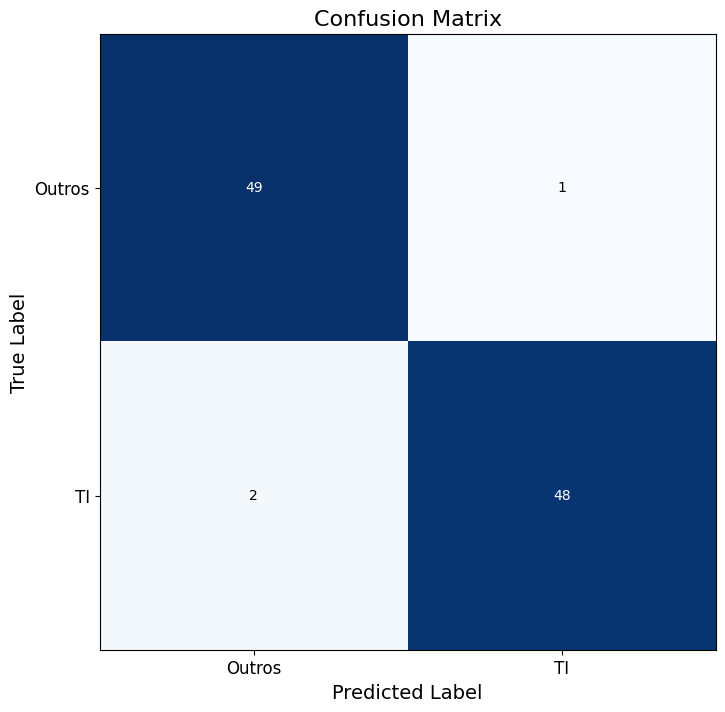

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



# Define class labels
class_names = ['Outros', 'TI']

# Define true labels and predicted labels

# Calculate confusion matrix
cm = confusion_matrix(labels, pred)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(labels, pred, average=None)
recall = recall_score(labels, pred, average=None)
f1 = f1_score(labels, pred, average=None)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks([0, 1], class_names, fontsize=12)
plt.yticks([0, 1], class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations for confusion matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f'{class_name} Precision: {precision[i]:.4f}')
    print(f'{class_name} Recall: {recall[i]:.4f}')
    print(f'{class_name} F1 Score: {f1[i]:.4f}')
    print('')

plt.show()

# Gera texto pelo modelo finetune

In [ ]:
import torch
from transformers import pipeline
import pandas as pd

# cpu
texts=[]

for key in ds_processado.keys():
    texts.append(ds_processado[key][0]['text'])
    texts.append(ds_processado[key][1]['text'])
model.to('cpu')
pred=[]

previous_level = transformers.logging.get_verbosity()
transformers.logging.set_verbosity_error()        

for text in texts:    
    pred.append(tokenizer.batch_decode(model.generate(tokenizer.encode(text,return_tensors='pt'),max_new_tokens=20,eos_token_id=tokenizer.eos_token_id)))

transformers.logging.set_verbosity(previous_level) ####

for i in range(0,len(texts)):
    print('input:',texts[i])
    print('generated:',pred[i])
    print('')

input: O objeto da presente licitação é de empresa para realização de serviços técnicos especializados na área de tecnologia da informação, contemplando a implantação e execução continuada das atividades de Gerenciamento e Operação da Central de Serviços de TIC de 1º, 2º e 3º níveis, para atender às necessidades da Universidade Federal da Bahia, em seus diversos órgãos e unidades situados nas cidades de Salvador, Vitória da Conquista, Oliveira dos Campinhos (Santo Amaro) e Camaçari, conforme condições, quantidades e exigências estabelecidas neste Edital e seus anexos.
generated: ['<|pad|>Outras compras<|endoftext|>']

input: Registro de Preços para futuras aquisições de material farmacológico (anastrozol, cisplatina, citarabina e outros) para o Hospital das Clínicas-UFG/EBSERH
generated: ['<|pad|>Outras compras<|endoftext|>']

input: REGISTRO DE PREÇOS para prestação de serviço de  emissão, renovação e validação de Certificados Digitais do tipo A3, pessoa  física (e-CPF), padrão ICP - 